# Investigating Appropriate Rank
In the first section, I am going to investigate what an appropriate rank to consider should be. It will make sense to look at the 
ranks of a trained matrix and a randomly initialized matrix. We will start by looking at a randomly initialized matrix and then
look at a trained matrix. Specifically, I will look at the rank of a randomly initialized matrix. I will need to consider the sizes 
that are seen in RoBERTa

In [1]:
# Import Appropriate Libraries
%load_ext autoreload
    
import torch
import matplotlib.pyplot as plt 
import bisect
import sys
sys.path.append("../")

In [2]:
def get_principle_direction(A, exp_var):
    U, S, V = torch.linalg.svd(A)
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    num = bisect.bisect(X, exp_var)
    return num

def plot_results(n=100, size=[768, 768], exp_var=0.99):
    results = []
    for _ in range(n):
        A = torch.randn(size)
        num = get_principle_direction(A, exp_var)
        results.append(num)
    return results

(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 53.]),
 array([515. , 515.1, 515.2, 515.3, 515.4, 515.5, 515.6, 515.7, 515.8,
        515.9, 516. ]),
 <BarContainer object of 10 artists>)

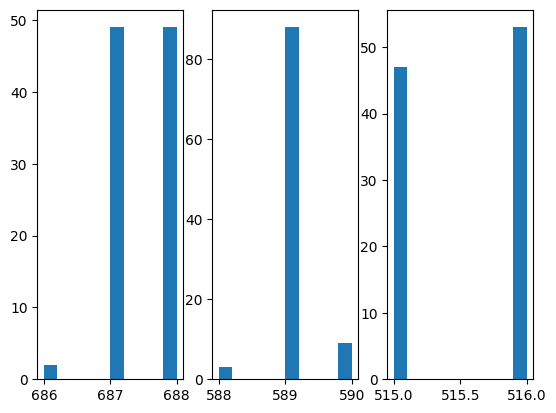

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].hist(plot_results())
ax[1].hist(plot_results(exp_var=0.95))
ax[2].hist(plot_results(exp_var=0.9))

The above results indicate the rank is very tightly distributed based on the explained variance. The reader is encouraged to play with the explained_variance and support the claim themselves.

In [ ]:
## Now let's look at how tightly the weights are distributed in RoBERTa 
roberta_large = torch.hub.load('pytorch/fairseq', 'roberta.large') 
roberta_base = torch.hub.load('pytorch/fairseq', 'roberta.base')

In [6]:
for key, param in roberta_base.named_parameters():
    with torch.no_grad():
        key = ".".join(key.split(".")[3:])
        p_size = min(param.size())
        if len(param.size()) < 2:
            print(key, p_size)
            continue
        print(key, get_principle_direction(param, 0.99), p_size)

embed_tokens.weight 745 768
embed_positions.weight 439 514
layernorm_embedding.weight 768
layernorm_embedding.bias 768
layers.0.self_attn.k_proj.weight 652 768
layers.0.self_attn.k_proj.bias 768
layers.0.self_attn.v_proj.weight 667 768
layers.0.self_attn.v_proj.bias 768
layers.0.self_attn.q_proj.weight 653 768
layers.0.self_attn.q_proj.bias 768
layers.0.self_attn.out_proj.weight 669 768
layers.0.self_attn.out_proj.bias 768
layers.0.self_attn_layer_norm.weight 768
layers.0.self_attn_layer_norm.bias 768
layers.0.fc1.weight 748 768
layers.0.fc1.bias 3072
layers.0.fc2.weight 748 768
layers.0.fc2.bias 768
layers.0.final_layer_norm.weight 768
layers.0.final_layer_norm.bias 768
layers.1.self_attn.k_proj.weight 649 768
layers.1.self_attn.k_proj.bias 768
layers.1.self_attn.v_proj.weight 665 768
layers.1.self_attn.v_proj.bias 768
layers.1.self_attn.q_proj.weight 644 768
layers.1.self_attn.q_proj.bias 768
layers.1.self_attn.out_proj.weight 662 768
layers.1.self_attn.out_proj.bias 768
layers.1.sel

In [8]:
# On the surface the above results suggest you need most of the directions to account for most of the directions. 
# It will be useful to see which directions are affected and how later.
from models.LoRA import LoRALinearLayer
def add_linear_lora(module, rank, init_type=0):
    for key, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            lora_layer =  LoRALinearLayer(child, rank=rank, init_type=init_type)
            setattr(module, key, lora_layer)
        else:
            add_linear_lora(child, rank, init_type)

In [9]:
add_linear_lora(roberta_base, rank=10, init_type=1)

In [10]:
roberta_base

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (v_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (q_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (out_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
            )
            (self_attn_layer_norm): LayerNorm